# 311 Calls in Gowanus

I lived in the Gowanus neighborhood of Brooklyn before the Whole Foods and before the Kentile Floors sign came down. Today, on the eve of an environmental clean up from the EPA, the neighborhood is rapidly gentrifying. The changes in the built environment are quite striking. In addition to construction introducing new housing stock, the neighborhood is investing in green space, making efforts to beautify the Superfund site. With so much change, arguably good and bad, I'm interested in how the neighborhood has voiced their concerns over time. 

### About 311
311 is the non-emergency call system that allows citizens to report issues in their neighborhood. Since its origin, it's been a quick snapshot of a region's pulse. Specifically, noise complaints have been used as one proxy to help understand gentrification. It speaks to the increase in people/parties, but also  to those who use the call line to report noise: those who are potentially less familiar with the baseline sounds of the neighborhood.

### The question
By looking at noise complaints in 311 data from 2010 - 2017, I hope to identify how — if at all — complaints in Gowanus deviate from Brooklyn's overall distribution. **How can this data-driven story help us explain _when_ the neighborhood changed?**

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from pandas import DataFrame
import matplotlib.pylab as plt
import shapely

# geofunctions 
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Preparing the data
The 311 dataset is available on OpenDataNYC from 2010 to present.I worked with data from Brooklyn only, and filtered to the four distinct types of noise complaints, below.


In [2]:
# import 311 data as found on Open Data NYC
brooklyn = pd.read_csv('Brooklyn_311.csv')


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# filter to only noise complaints from brooklyn
noise = ['Noise - Residential', 'Noise', 'Noise - Street/Sidewalk', 'Noise - Commercial']
brooklyn = brooklyn[brooklyn['Complaint Type'].isin(noise)]
print (brooklyn.shape)
brooklyn.head()

(664116, 10)


,Unique Key,Created Date,Complaint Type,Descriptor,Incident Zip,Incident Address,Community Board,Borough,Latitude,Longitude
0,31463993,09/05/2015 01:06:57 AM,Noise - Commercial,Loud Music/Party,11203,UTICA AVENUE,17 BROOKLYN,BROOKLYN,40.640965,-73.929232
4,31464004,09/04/2015 11:16:12 PM,Noise - Street/Sidewalk,Loud Music/Party,11238,NaN,08 BROOKLYN,BROOKLYN,40.671645,-73.962574
5,31464007,09/04/2015 04:49:55 PM,Noise - Commercial,Loud Talking,11216,1266 BEDFORD AVENUE,03 BROOKLYN,BROOKLYN,40.680499,-73.953353
7,31464012,09/04/2015 11:44:07 PM,Noise - Street/Sidewalk,Loud Music/Party,11226,2315 NEWKIRK AVENUE,14 BROOKLYN,BROOKLYN,40.639320,-73.955447
8,31464013,09/04/2015 08:12:10 AM,Noise - Street/Sidewalk,Loud Music/Party,11238,1067 PACIFIC STREET,08 BROOKLYN,BROOKLYN,40.678920,-73.957912


___
### Geopandas: Finding Gowanus
The location designations available in the 311 dataset is not granular enough to look at the neighborhood on its own. 

To isolate Gowanus, I combined the lat and long provided in each call, and used the shapely package to convert them to the appropriate geometry, and to a geodataframe. This ensured that the lat/longs were meaningful, tied to a real geographic projection.

Next, I created a polygon for Gowanus using the lat/long coordinates of the four corners of the neighborhood. From there, I could identify which 311 calls fell within that area, and create a new dataframe with that subset.

In [4]:
print (brooklyn.columns)

Index([u'Unique Key', u'Created Date', u'Complaint Type', u'Descriptor',
       u'Incident Zip', u'Incident Address', u'Community Board', u'Borough',
       u'Latitude', u'Longitude'],
      dtype='object')


In [5]:
# combine lat and lon to one column
brooklyn['lonlat'] = zip(brooklyn['Longitude'], brooklyn['Latitude'])

# create a point geometry for lat long column
brooklyn['geometry'] = brooklyn[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

# convert back into a geodataframe
geometry = brooklyn.geometry
crs = {'init': 'epsg:4326'}
brooklyn = GeoDataFrame(brooklyn, crs=crs, geometry=geometry)

# let's see what we're working with 
brooklyn.head(1)

,Unique Key,Created Date,Complaint Type,Descriptor,Incident Zip,Incident Address,Community Board,Borough,Latitude,Longitude,lonlat,geometry
0,31463993,09/05/2015 01:06:57 AM,Noise - Commercial,Loud Music/Party,11203,UTICA AVENUE,17 BROOKLYN,BROOKLYN,40.640965,-73.929232,"(-73.9292319408, 40.6409646447)",POINT (-73.92923194083798 40.64096464471428)


In [6]:
# creating polygon to designate gowanus neighborhood using shapely package
gowanus_poly = Polygon([(-73.989640, 40.684013), (-73.980969, 40.680777),
                   (-73.991827, 40.666839), (-73.998821, 40.674042)])

In [7]:
# create boolean list that answers the question, "does this lat/long point fall within the polygon?
# points within polygon 311 calls from the gowanus neighborhood
is_gowanus = []

for i in brooklyn.geometry: 
    is_gowanus.append(gowanus_poly.contains(i)[0])

In [8]:
# add a columm to the brooklyn data frame that contains T/F from our list
brooklyn['is_gowanus'] = is_gowanus

In [9]:
# check out the split
brooklyn['is_gowanus'].value_counts()

False    656854
True       7262
Name: is_gowanus, dtype: int64

In [10]:
# Create a new dataframe just for the Gowanus neighborhood
gowanus = brooklyn[brooklyn['is_gowanus'] == True]
gowanus.head()

,Unique Key,Created Date,Complaint Type,Descriptor,Incident Zip,Incident Address,Community Board,Borough,Latitude,Longitude,lonlat,geometry,is_gowanus
152,31464709,09/04/2015 09:07:55 PM,Noise - Commercial,Loud Music/Party,11217,622 DEGRAW STREET,06 BROOKLYN,BROOKLYN,40.679154,-73.983430,"(-73.9834299276, 40.6791541332)",POINT (-73.98342992763081 40.67915413315733),True
190,31464869,09/04/2015 10:30:37 PM,Noise - Commercial,Loud Music/Party,11217,622 DEGRAW STREET,06 BROOKLYN,BROOKLYN,40.679154,-73.983430,"(-73.9834299276, 40.6791541332)",POINT (-73.98342992763081 40.67915413315733),True
1169,31469062,09/05/2015 11:38:34 PM,Noise - Residential,Loud Music/Party,11215,51 2 AVENUE,06 BROOKLYN,BROOKLYN,40.673855,-73.992321,"(-73.9923212686, 40.6738549107)",POINT (-73.99232126857012 40.67385491074012),True
1866,31471684,09/05/2015 11:33:48 PM,Noise - Commercial,Loud Music/Party,11217,622 DEGRAW STREET,06 BROOKLYN,BROOKLYN,40.679154,-73.983430,"(-73.9834299276, 40.6791541332)",POINT (-73.98342992763081 40.67915413315733),True
2417,31473676,09/07/2015 12:32:26 AM,Noise - Street/Sidewalk,Loud Music/Party,11217,NaN,06 BROOKLYN,BROOKLYN,40.681520,-73.983263,"(-73.9832634889, 40.6815201035)",POINT (-73.98326348891726 40.68152010351562),True


___
# Data exploration
I grouped data by year and complaint type in order to visualize the data over time. The plots below show how Brooklyn and Gowanus complaints have evolved. These two plots show the same general trend of increasing calls overall throughout the years, but do deviate from each other in terms of the types of noise complaints coming in. This is worth investigating further. 

In [11]:
brooklyn['Complaint Type'].value_counts()

Noise - Residential        407389
Noise                       91143
Noise - Commercial          84086
Noise - Street/Sidewalk     81498
Name: Complaint Type, dtype: int64

In [12]:
gowanus['Complaint Type'].value_counts()

Noise - Commercial         4222
Noise - Residential        1516
Noise                      1181
Noise - Street/Sidewalk     343
Name: Complaint Type, dtype: int64

In [13]:
# make the created date column datetime for later analysis
brooklyn['Created Date'] = pd.to_datetime(brooklyn['Created Date'])
gowanus['Created Date'] = pd.to_datetime(gowanus['Created Date'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
# creating month and year for our two datasets so we can groupby month in our analysis
brooklyn['year'] = brooklyn['Created Date'].dt.year
brooklyn['month'] = brooklyn['Created Date'].dt.month

# and for gowanus too
gowanus['year'] = gowanus['Created Date'].dt.year
gowanus['month'] = gowanus['Created Date'].dt.month

# there is certainly a better way to do this than the above...

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
# let's see what we're working with
print (brooklyn.shape)
print (gowanus.shape)
brooklyn.columns

(664116, 15)
(7262, 15)


Index([u'Unique Key', u'Created Date', u'Complaint Type', u'Descriptor',
       u'Incident Zip', u'Incident Address', u'Community Board', u'Borough',
       u'Latitude', u'Longitude', u'lonlat', u'geometry', u'is_gowanus',
       u'year', u'month'],
      dtype='object')

In [16]:
# create new df to isolate complaint counts over time
br_complaints = brooklyn[["year", "Complaint Type", "Unique Key"]]
gw_complaints = gowanus[["year", "Complaint Type", "Unique Key"]]

In [17]:
# group by year to see count of unstacked over time
df_brook = br_complaints.groupby(['year', 'Complaint Type'])['Unique Key'].count().unstack('Complaint Type')
df_gw = gw_complaints.groupby(['year', 'Complaint Type'])['Unique Key'].count().unstack('Complaint Type')

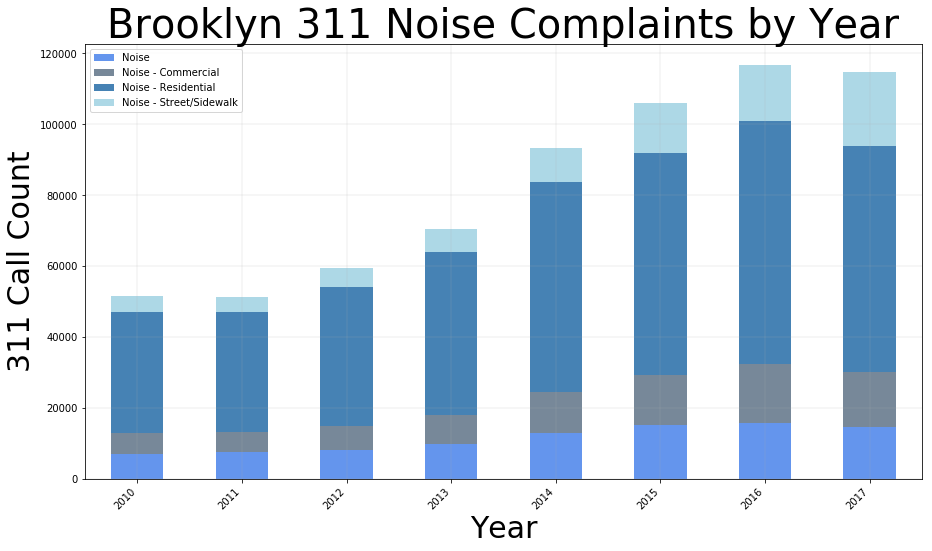

In [18]:
# for brooklyn
df_brook.plot(kind='bar', stacked=True, figsize=(15,8), color=('cornflowerblue', 'lightslategrey', 'steelblue', 'lightblue'))
plt.title('Brooklyn 311 Noise Complaints by Year', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2) 
savefig('BK_complaints_stacked.png', bbox_inches='tight')









**Fig 1** This stacked bar plot shows the steady increase of noise complaints in all of Brooklyn  via 311, from 2010 to 2017 to date. Notice that overall, "Residential" noise has the most complaints consistently. 
___

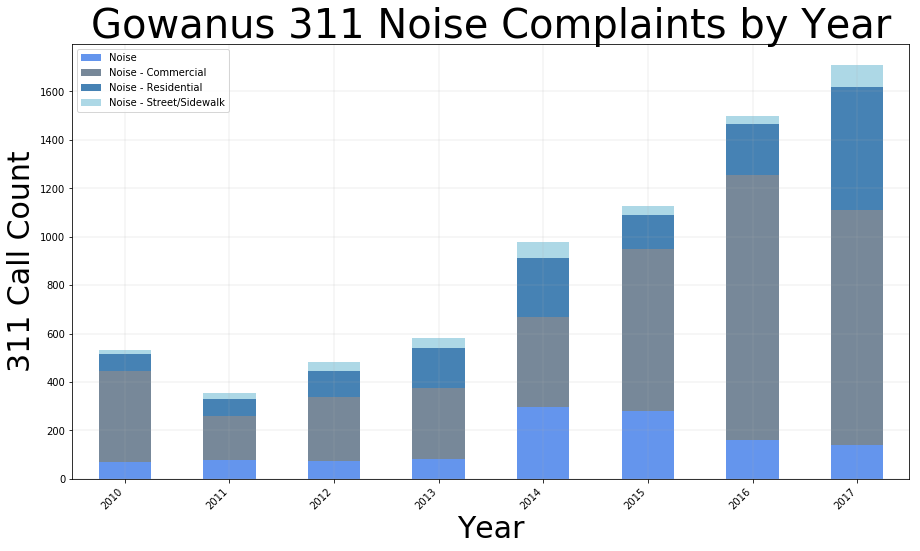

In [19]:
# and for gowanus
df_gw.plot(kind='bar', stacked=True, figsize=(15,8), color=('cornflowerblue', 'lightslategrey', 'steelblue', 'lightblue'))
plt.title('Gowanus 311 Noise Complaints by Year', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2) 
# savefig('Gowanus_complaints_stacked.png', bbox_inches='tight')


**Fig 2** This stacked bar plot shows the steady increase of noise complaints in the Gowanus area specifically over the same period of time as Fig. 1. Instead of Residential noise, the Gowanus area has the majority of calls regarding Commercial noise, shown in gray. The amount of calls seems to expand to be the majority of all noise calls in 2016 especially, a pattern distinct from Brooklyn overall. 

___
# Using a rolling mean to visually assess stationarity

First, I created a timeseries column "ts" which extracted the month and year for calls. Grouping by this new metric, I was able to create a count of noise complaint call per month since 2010. Because there are relatively few months worth of data (fewer than 100), it may be possible to view these trends visually. The following plots show the data over time, with a rolling mean window of 10. 

In [20]:
# creating time series column with just month and year
gowanus["ts"] = gowanus["year"].map(str) + "-" + gowanus["month"].astype(str)
brooklyn["ts"] = brooklyn["year"].map(str) + "-" + brooklyn["month"].astype(str)

# changing to datetime
gowanus['ts'] = pd.to_datetime(gowanus['ts'])
brooklyn['ts'] = pd.to_datetime(brooklyn['ts'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# looks at count of all noise complaints by month for gowanus
station_gw = gowanus.groupby('ts').count().reset_index()
station_bk = brooklyn.groupby('ts').count().reset_index()

# shorten df
station_gw = station_gw[['ts', 'Descriptor']]
station_bk = station_bk[['ts', 'Descriptor']]

In [22]:
brooklyn_rmean = pd.rolling_mean(station_bk.Descriptor, 10, center=True)
gw_rmean = pd.rolling_mean(station_gw.Descriptor, 10, center=True)



/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=True).mean()
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=True).mean()
  from ipykernel import kernelapp as app


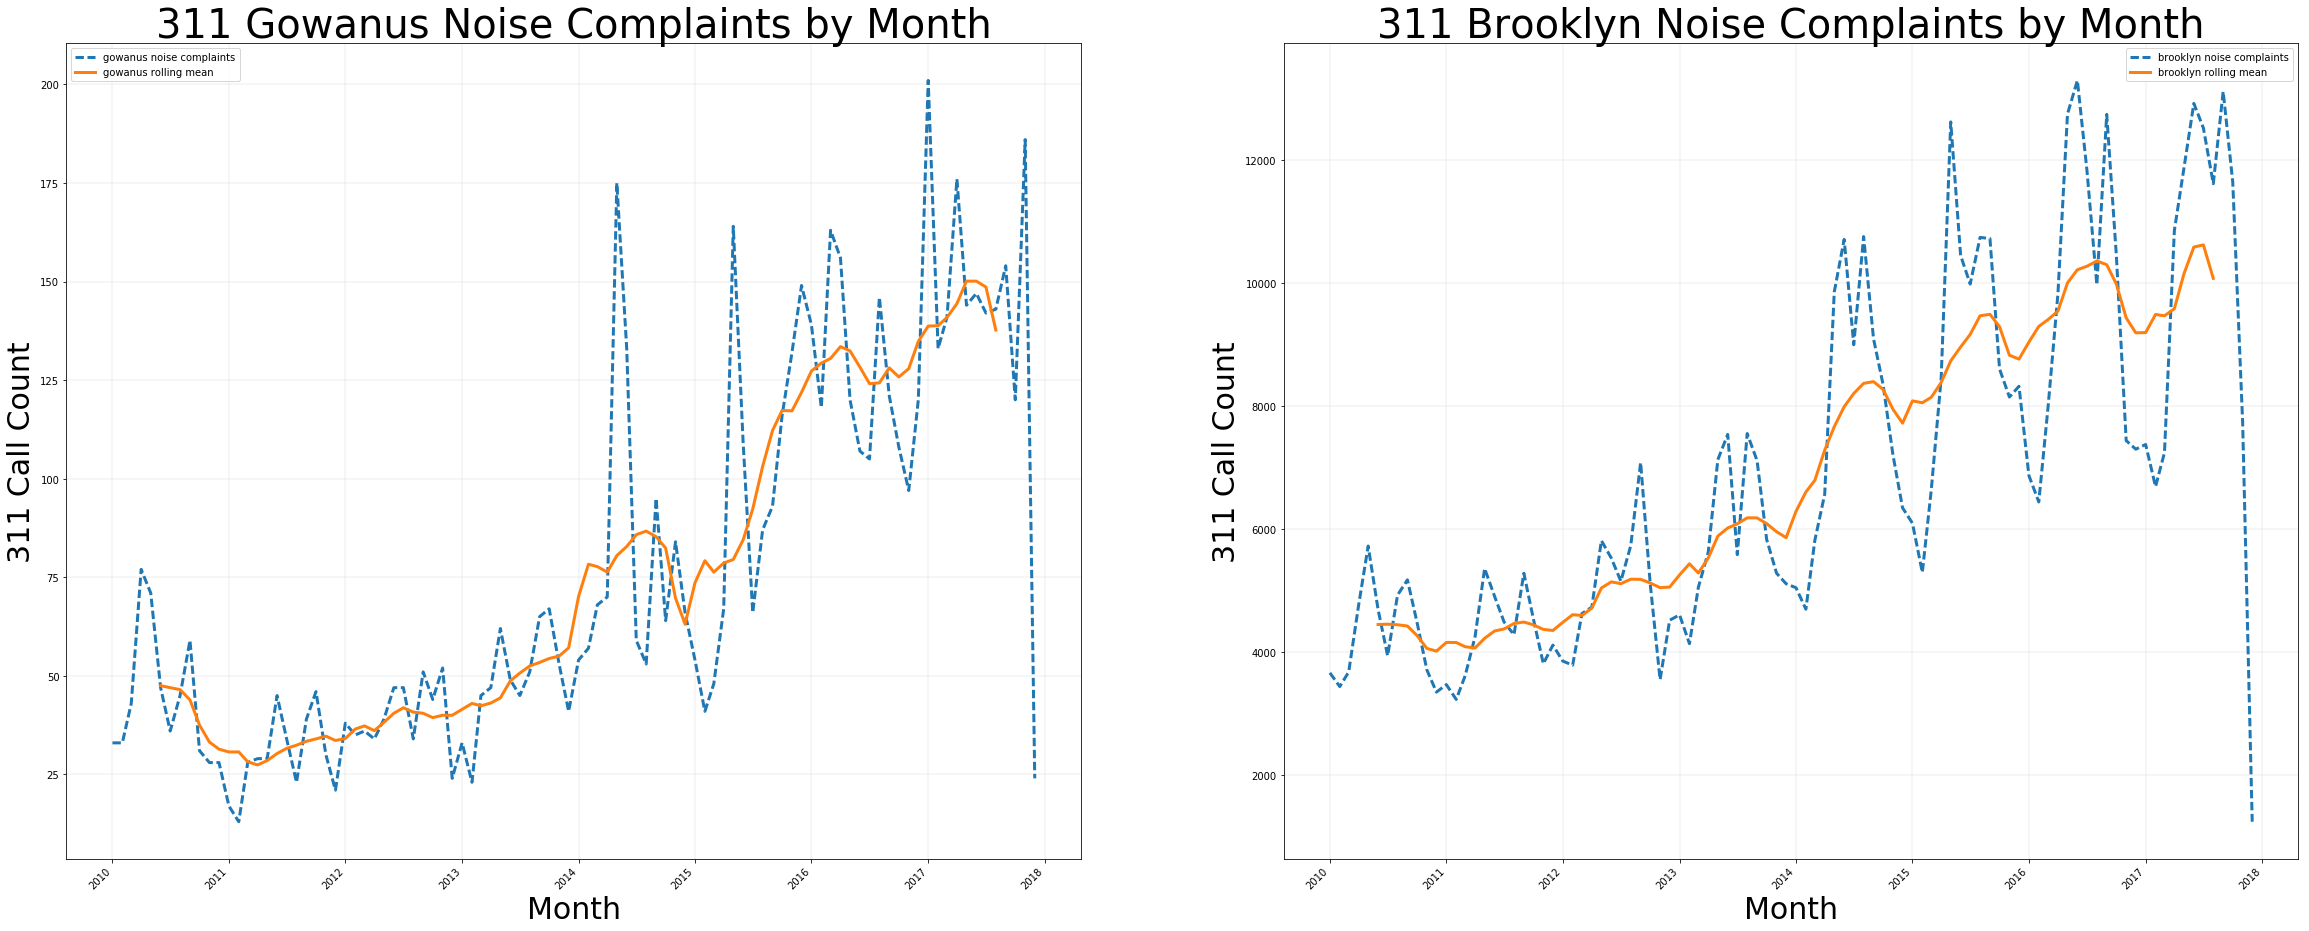

In [23]:
# plotting volume of 311 noise complaints over time
# using rolling means to visually assess stationarity with timeseries data

fig = plt.figure(figsize=(40,15))

# for our gowanus data
ax = fig.add_subplot(121)
ax.plot(station_gw.ts, station_gw.Descriptor, '--', label='gowanus noise complaints', linewidth=3)
ax.plot(station_gw.ts, gw_rmean, label="gowanus rolling mean", linewidth=3)
plt.title('311 Gowanus Noise Complaints by Month', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Month', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2)

# for our brooklyn data (including gowanus)
ax = fig.add_subplot(122)
ax.plot(station_bk.ts, station_bk.Descriptor, '--', label='brooklyn noise complaints', linewidth=3)
ax.plot(station_bk.ts, brooklyn_rmean, label="brooklyn rolling mean", linewidth=3)
plt.title('311 Brooklyn Noise Complaints by Month', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Month', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2) 

#savefig('complaints_by_month_bk-gw.png', bbox_inches='tight')

**Fig 3** These plots show the volume of complaints over time, by moth, in Gowanus and Brooklyn respectively from 2010 to Dec 2017. Notice that the general trends of the rolling means follow roughly the same pattern, steadily increasing as time goes on. The Brooklyn plot appears to have more regular seasonality, while the Gowanus plot has a few interesting spikes that may be interesting in spring/summer of 2014. In 2017, there's another spike in the winter that doesn't seem to be reflected in the overall Brooklyn plot. 

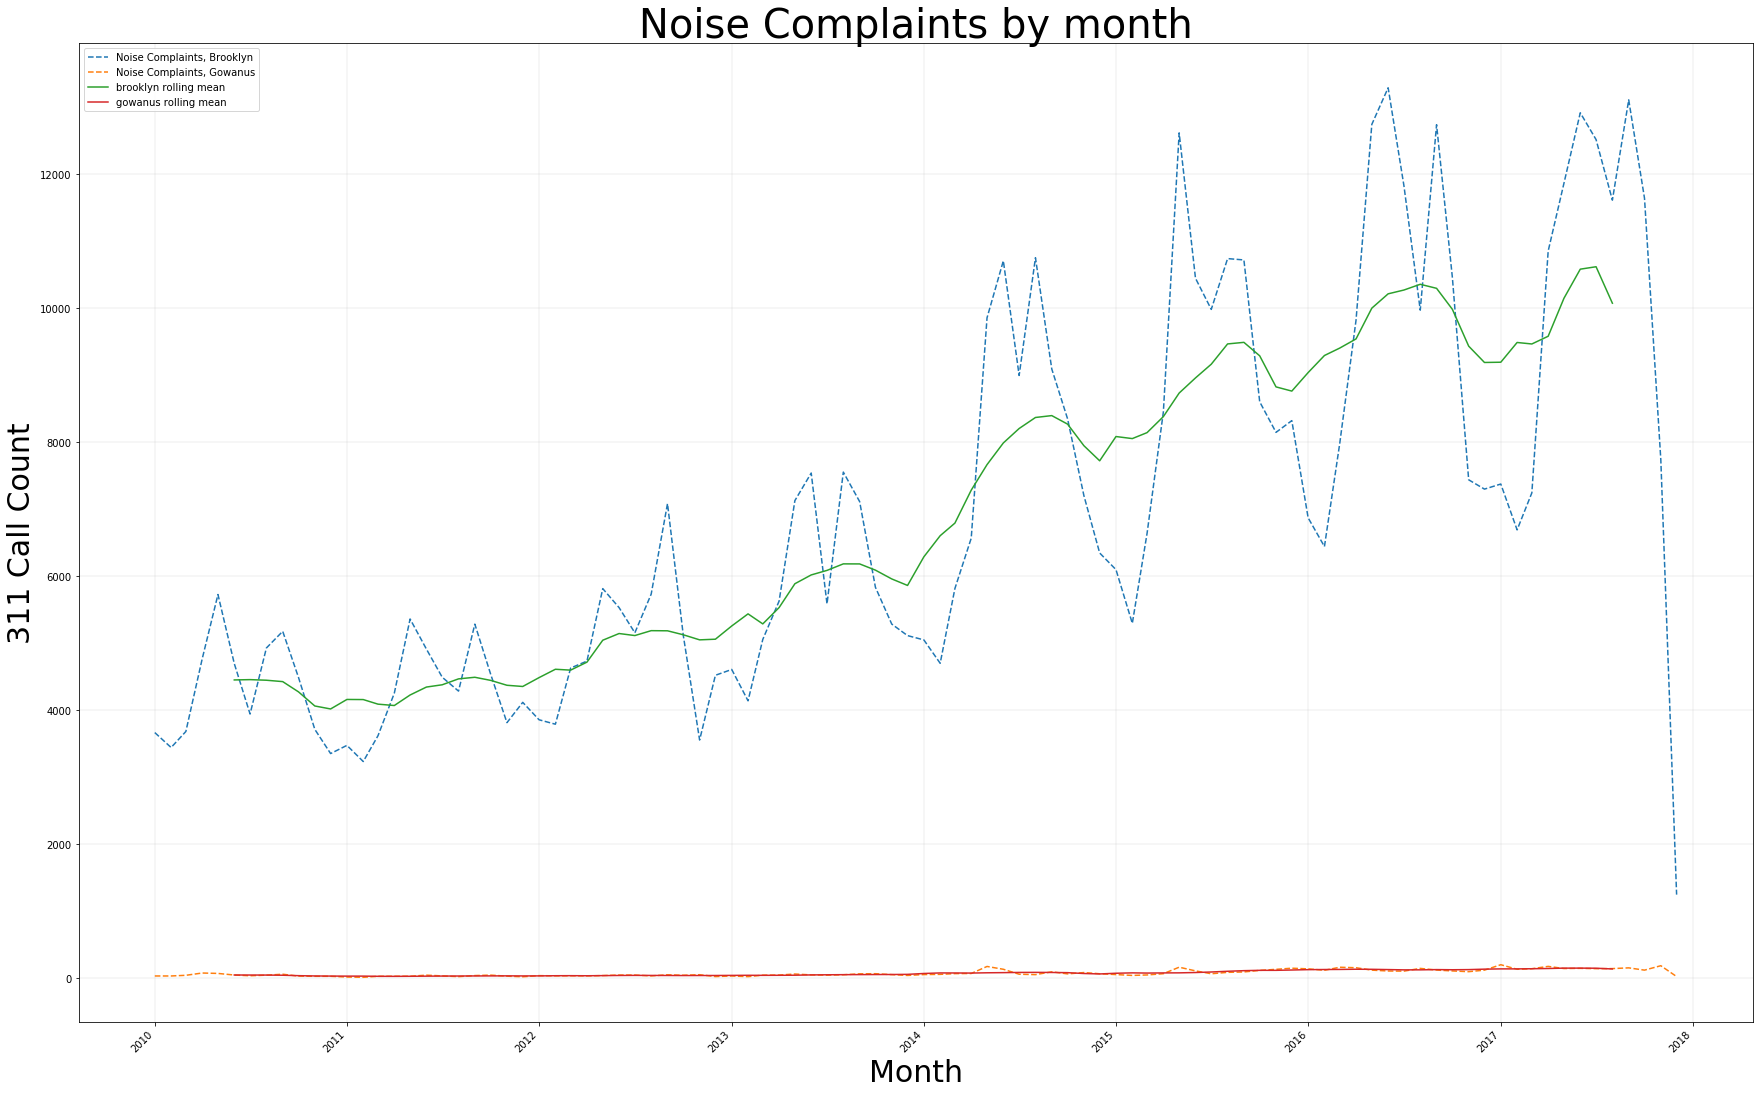

In [24]:
# looking at volume of calls for both regions on same graph to see if we can spot different trends
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

# plotting with both dataframes
ax.plot(station_bk.ts, station_bk.Descriptor, '--', label='Noise Complaints, Brooklyn')
ax.plot(station_gw.ts, station_gw.Descriptor, '--', label='Noise Complaints, Gowanus')
ax.plot(station_bk.ts, brooklyn_rmean, label="brooklyn rolling mean")
ax.plot(station_gw.ts, gw_rmean, label="gowanus rolling mean")
plt.title('Noise Complaints by month', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Month', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2) 

**Fig 4** This looks at both Gowanus and all of Brooklyn on the same graph. Due to the low volume of calls, it hard to infer anything here. Instead, we'll need to do some formal stationarity tests.

# Creating stationarity formally using ratio
I made the Gowanus data a ratio. Instead of using the total number of noise complaints which increase over time, I looked at the percentage of noise complaints from Gownaus, compared to the rest of Brooklyn. 

Using this normalized data, we can really get to the core of our question about neighborhood change (or, 311 noise complaint behavior). I chose to use an AD Fuller test to assess stationarity. The AD Fuller test's null hypothesis is that there's a unit root, meaning there is not stationarity. If we can reject the null, it generally means the data is stationary.

In [25]:
# create ratio column
station_gw['ratio'] = station_gw.Descriptor / station_bk.Descriptor
station_gw.head()

,ts,Descriptor,ratio
0,2010-01-01,33,0.009004
1,2010-02-01,33,0.009587
2,2010-03-01,43,0.011682
3,2010-04-01,77,0.016166
4,2010-05-01,71,0.012402


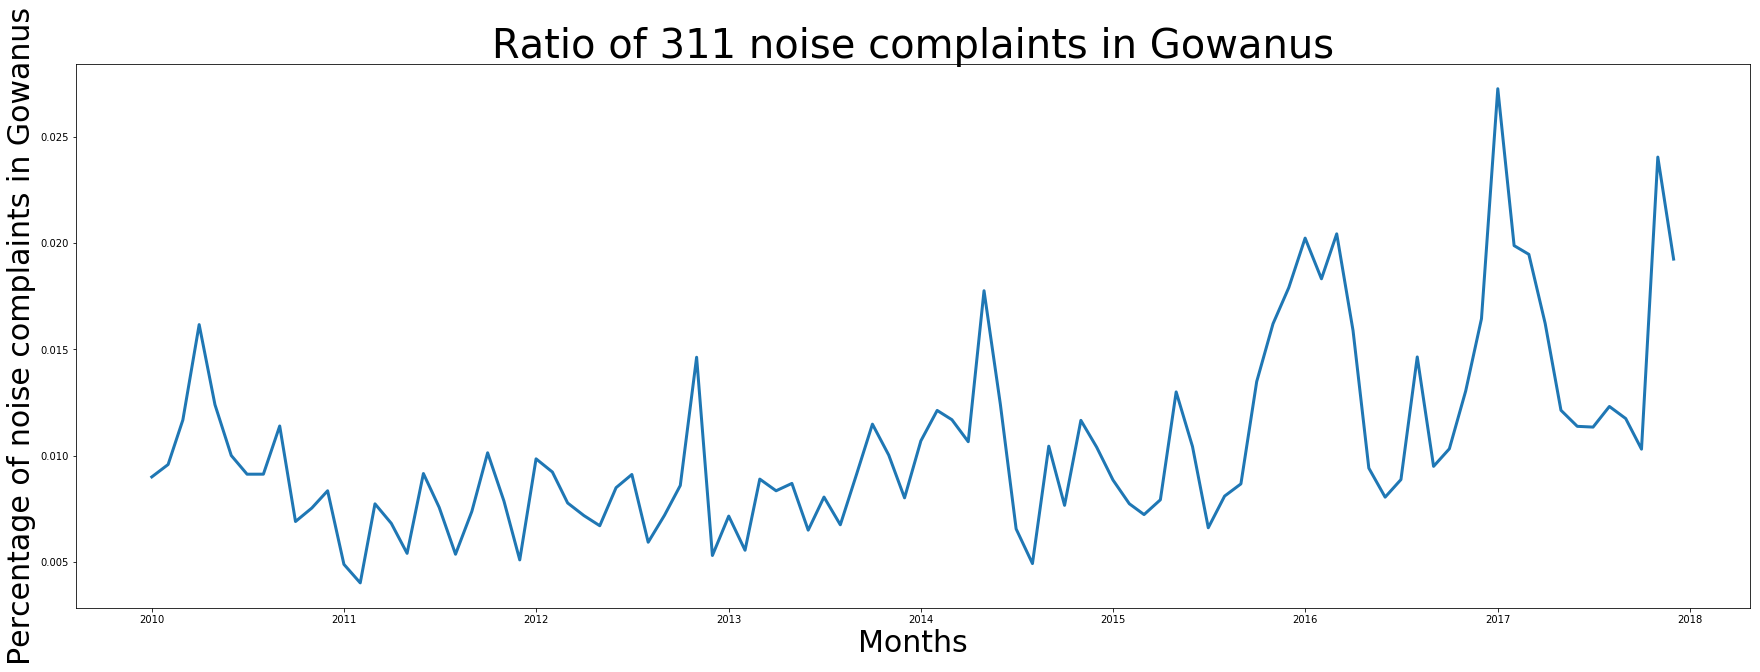

In [26]:
# looking at calls as a percentage of all of brooklyn

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
ax.plot(station_gw.ts, station_gw.ratio, '-', linewidth=3)
plt.title('Ratio of 311 noise complaints in Gowanus', fontsize=40)
plt.ylabel('Percentage of noise complaints in Gowanus', fontsize=30)
plt.xlabel('Months', fontsize=30)
savefig('ratio_gowanus_complaints.png', bbox_inches='tight')


**Fig 5** This plot shows the percentage of noise complaints in Gowanus, compared to the rest of Brooklyn. You'll notice that the plot seems pretty steady over time, with a few potential points of change in 2016 and 2017. 

In [27]:
# running AD Fuller test
print ('pvalue for AD Fuller test: {}'.format(sm.tsa.adfuller(station_gw['ratio'])[1]))

pvalue for AD Fuller test: 0.00132174112652


#### Interpretation: For all noise complaints - no, ratio is stationary
The null hypothesis is that there IS a unit root, meaning the series is not stationary. P value is close to zero meaning we can reject the null. The series is stationary. non stationary = unit root.

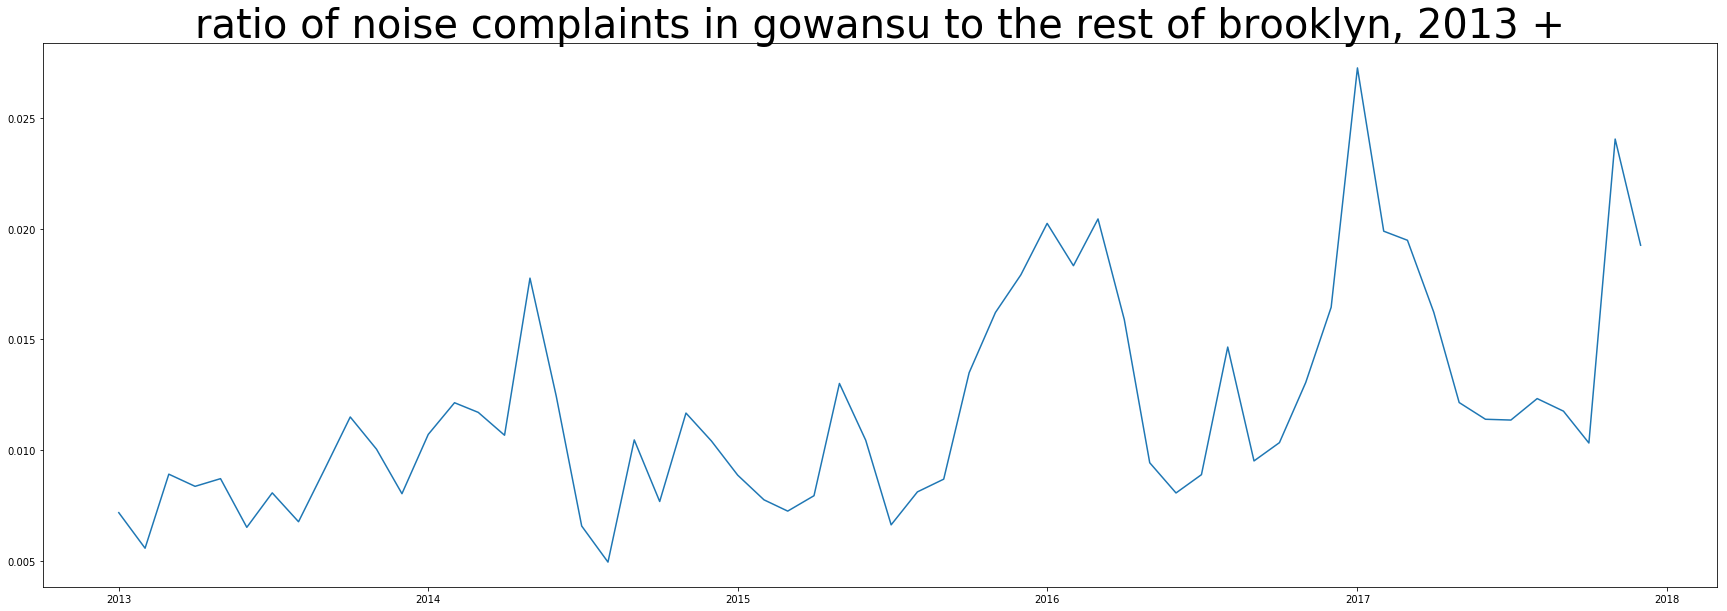

In [28]:
# Looking at stationarity from recent years
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
ax.plot(station_gw.ts[36:], station_gw.ratio[36:], '-')
plt.title('ratio of noise complaints in gowansu to the rest of brooklyn, 2013 +', fontsize=40)


**Fig 6** Looking at ratio for just the past five years shows similar results, although there appears to be spikes in 2016 and 2017, respectively.

In [29]:
# still staionary, even when looking at the past few years (all noise)
print ('pvalue for AD Fuller test: {}'.format(sm.tsa.adfuller(station_gw['ratio'][36:])[1]))


pvalue for AD Fuller test: 0.0168039624274


# Look at the change for just Commercial Noise
Seeing the results of the stationarity test was a bit surprising, but it may not tell the full story. One larger deviation from our exploratory analysis showed that there were large deviations in noise complaint subdivisions. To look at these in particular, I duplicated the analysis, looking at only Commercial noise complaints. 

In [30]:
gw_commercial = gowanus.loc[gowanus['Complaint Type'] == "Noise - Commercial"]
bk_commercial = brooklyn.loc[brooklyn['Complaint Type'] == "Noise - Commercial"]

In [31]:
gw_commercial["ts"] = gw_commercial["year"].map(str) + "-" + gw_commercial["month"].astype(str)
bk_commercial["ts"] = bk_commercial["year"].map(str) + "-" + bk_commercial["month"].astype(str)

# changing to datetime
gw_commercial['ts'] = pd.to_datetime(gw_commercial['ts'])
bk_commercial['ts'] = pd.to_datetime(bk_commercial['ts'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [32]:
gw_commercial = gw_commercial.groupby('ts').count().reset_index()
bk_commercial = bk_commercial.groupby('ts').count().reset_index()

gw_commercial = gw_commercial[['ts', 'Descriptor']]
bk_commercial = bk_commercial[['ts', 'Descriptor']]


In [33]:
gw_commercial.head()

,ts,Descriptor
0,2010-01-01,20
1,2010-02-01,26
2,2010-03-01,35
3,2010-04-01,53
4,2010-05-01,50


In [34]:
bk_comm_rmean = pd.rolling_mean(bk_commercial.Descriptor, 2, center=True)
gw_comm_rmean = pd.rolling_mean(gw_commercial.Descriptor, 2, center=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=True).mean()
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=True).mean()
  from ipykernel import kernelapp as app


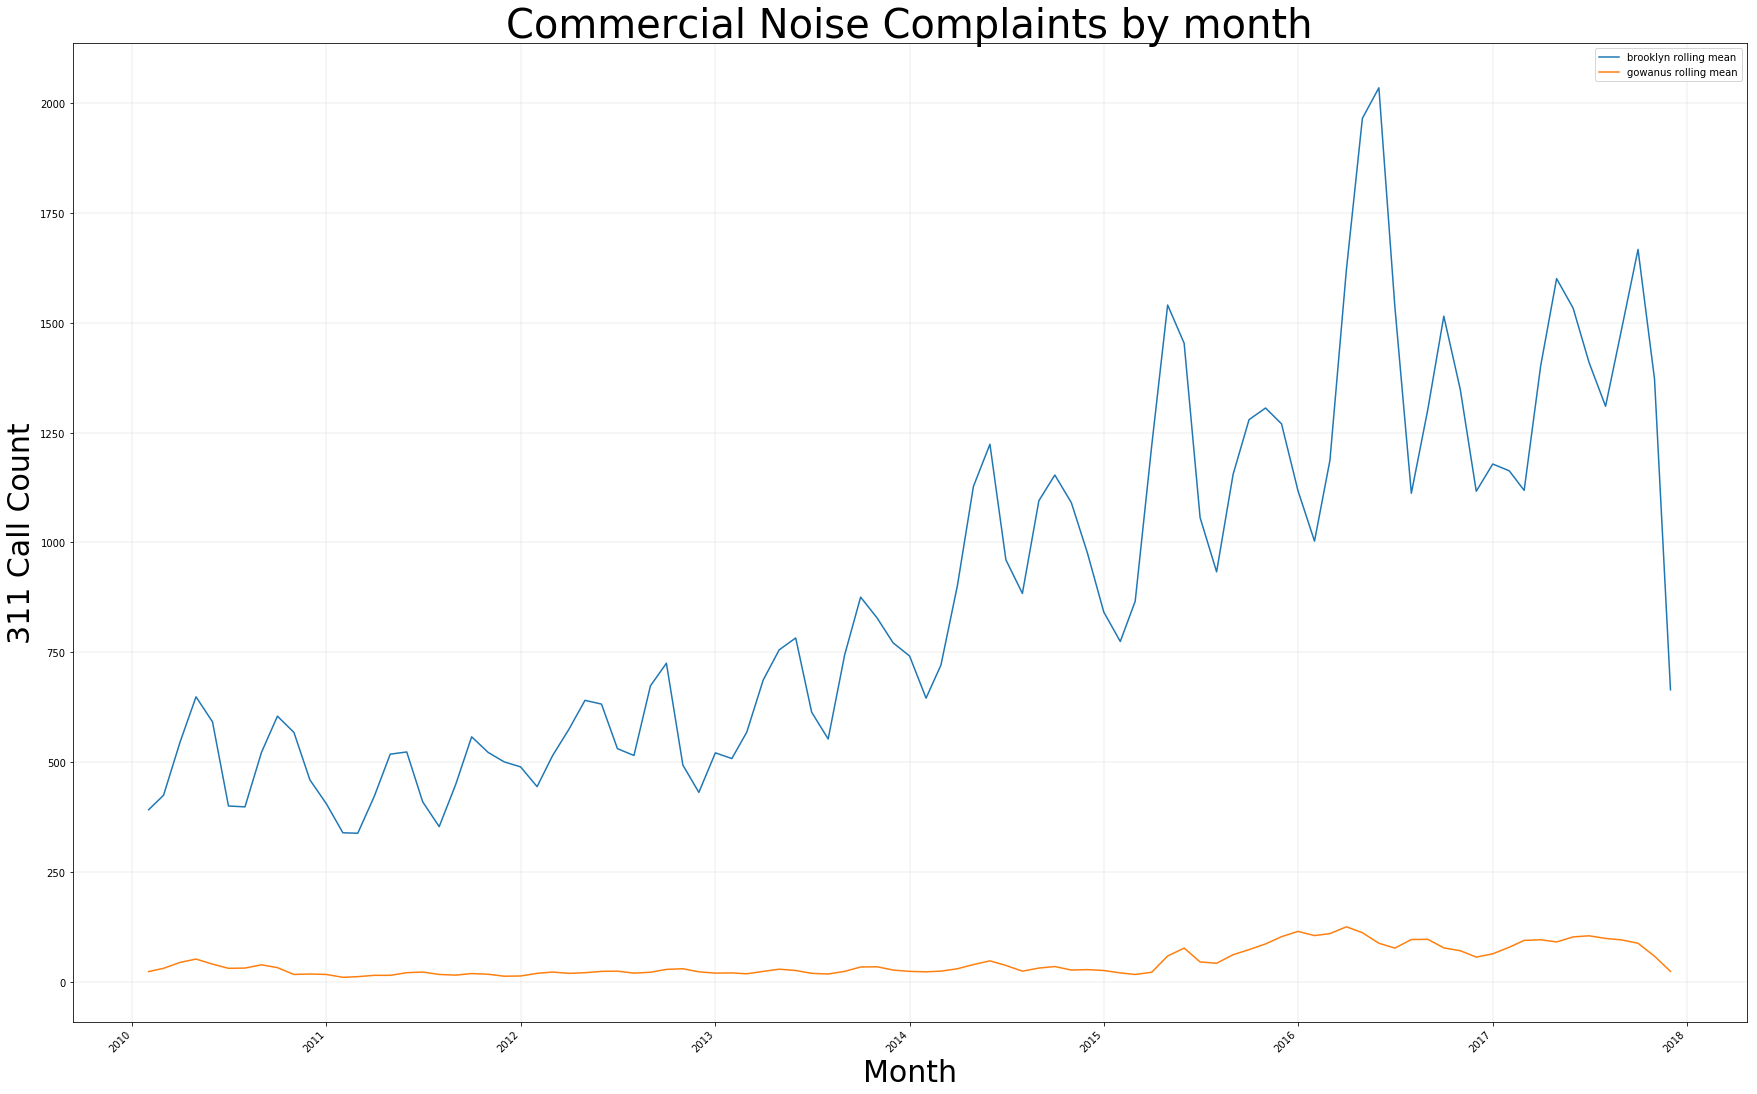

In [35]:
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

# look at rolling means of just noise - commercial
ax.plot(bk_commercial.ts, bk_comm_rmean, label="brooklyn rolling mean")
ax.plot(gw_commercial.ts, gw_comm_rmean, label="gowanus rolling mean")

plt.title('Commercial Noise Complaints by month', fontsize=40)
plt.ylabel('311 Call Count', fontsize=30)
plt.xlabel('Month', fontsize=30)
plt.legend()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2) 


**Fig 7** This looks at the rolling mean for just commercial noise over time. Here, the two dataframes seem to be different in recent years.

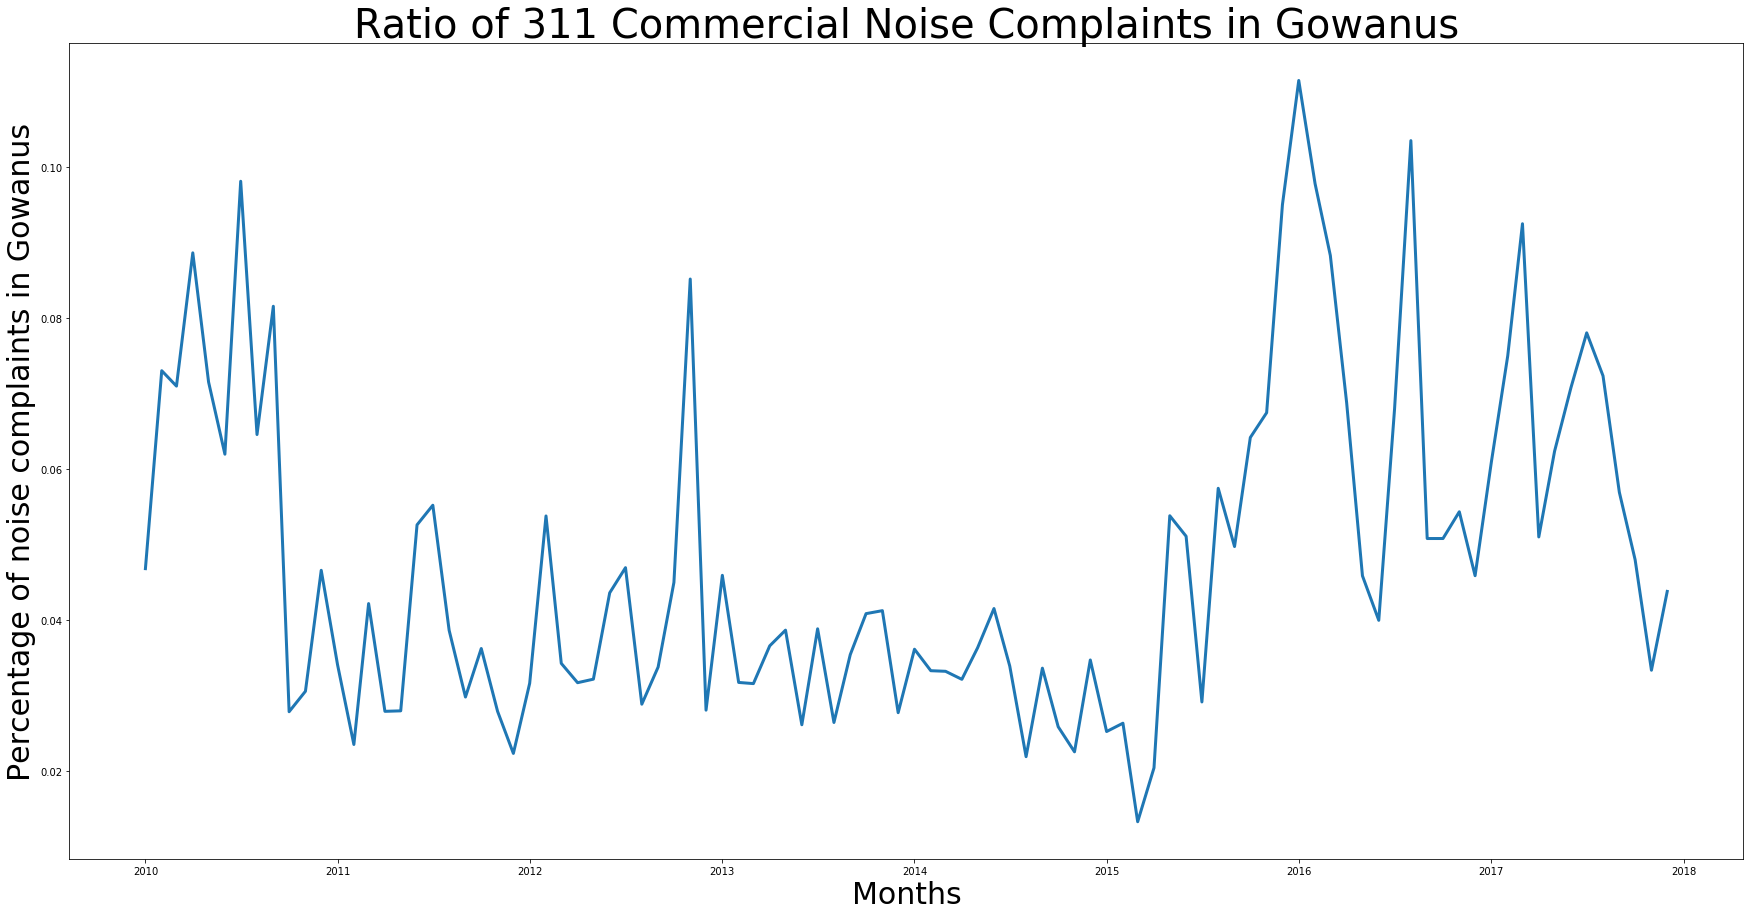

In [36]:
# creating ratio for new df
gw_commercial['ratio'] = gw_commercial.Descriptor / bk_commercial.Descriptor

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)

ax.plot(gw_commercial.ts, gw_commercial.ratio, '-', linewidth=3)
plt.title('Ratio of 311 Commercial Noise Complaints in Gowanus', fontsize=40)
plt.ylabel('Percentage of noise complaints in Gowanus', fontsize=30)
plt.xlabel('Months', fontsize=30)

# savefig('ratio_gowanus_complaints_commercial.png', bbox_inches='tight')

**Fig 8** This plot looks at the percentage of commercial noise complaints over time in the Gowanus area. Unlike all noise complaints over time, this plot show what appears to be major deviation in the past few years.

In [37]:
print ('pvalue for AD Fuller test (gowanus commercial noise): {}'.format(sm.tsa.adfuller(gw_commercial['ratio'][40:])[1]))


pvalue for AD Fuller test (gowanus commercial noise): 0.0541560737302


### Interpretation: these data are not stationary
When looking at commercial noise in isolation, there appears to be a distinct spike in 2016 and 2017. When conducting the AD Fuller test for the past five years in particular, we get a p-value of 0.0541. Here, we cannot reject the null, meaning these data are not stationary.  

___
# Limitations and conclusion
The results of our tests show that while these noise complaint data are stationary overall, they are not stationary for certain complaint types within Gowanus. The top Descriptor  for "Noise - Commercial" is "Loud Music/Partying." This could mean that as the neighborhood gentrified, there have been more loud parties that disturb residents. 

However, all it really means for sure is that more people are calling about the loud parties. This brings up an interesting limitation of this study, that gets at the core of our original question: there is known bias in 311 reporting, including studies that investigate the ratio of reports to actual violations. Although it's hard to draw concrete conclusions from the data due to its bias, we can still use this data driven anecdote to support "there goes the neighborhood" claims. 

Next steps on this project would be to investigate if there are any **points of change** (areas that deviate over 3 sigma from the mean), and two sample **KS Tests** to look at commercial noise in particular to see if they come from the same distributions the larger Brooklyn. 